<a href="https://colab.research.google.com/github/Above02/MC/blob/main/monte_carlo_hydrogen_tank_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo simulation of failure probability of a hydrogen tank


This notebook contains an introduction to use of Python and the NumPy library for Monte Carlo simulation applied to a mechanical design problem, used for estimating failure probability. 

**Acknowledgement**. The problem description in this notebook is taken from [UQWorld](https://uqworld.org/t/liquid-hydrogen-tank-problem/58), who themselves extracted the problem from the article by Bichon et al in 2011 cited below. 

In [ ]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use("bmh")

## Problem statement

The 5-dimensional liquid hydrogen tank problem is a reliability analysis benchmark problem (Bichon et al., 2011). The problem consists in quantifying the failure probability of a liquid hydrogen fuel tank on a space launch vehicle. The structure of the tank is subjected to stresses caused by ullage (empty space) pressure, head pressure (caused by the weight of the fuel), axial forces due to acceleration, and bending and shear stresses caused by the weight of the fuel.


Three different failure modes exist for the tank:

- [Von Mises stress](https://en.wikipedia.org/wiki/Von_Mises_yield_criterion) failure ($PVM$)
- Isotropic strength failure ($PIS$)
- Honeycomb buckling failure ($PHB$)


The limit state function of the overall system is then defined as:

$$g(x) = \min(PVM, PIS, PHB)$$

where:

$$PVM = \frac{8400 \cdot t_{plate}}{\sqrt{N_x^2 + N_y^2 - N_xN_y + 3N_{xy}^2}} - 1$$

$$PIS = \frac{8400 \cdot t_{plate}}{|Ny|} - 1$$

$$PHB = 0.847 + 0.96 \cdot x_1 + 0.986 \cdot x_2 - 0.216 \cdot x_3 + 0.077 \cdot x_1^2 + 0.11 \cdot x_2^2
+ 0.007 \cdot x_3^2 + 0.378 \cdot x_1x_2 - 0.106 \cdot x_1x_3 - 0.11 \cdot x_2x_3$$

and:

$x_1 = 4 * (t_{plate} - 0.075)$

$x_2 = 20 * (t_h - 0.1)$

$x_3 = -6000 * (\frac{1}{N_{xy}} + 0.003)$

The failure event is defined as $g(x) ≤ 0$ (this means that one or more of PVM, PIS and PHB have failed).

Source article: B. J. Bichon, J. M. McFarland, and S. Mahadevan, “Efficient surrogate models for reliability analysis of systems with multiple failure modes”, Reliability Engineering & System Safety, 96(10):1386-1395, 2011. DOI: [10.1016/j.ress.2011.05.008](https://doi.org/10.1016/j.ress.2011.05.008). 

## Input variables

We will make the following **assumptions** concerning the distribution of our input variables, which we assume are independent:

| Name        | Distribution           | Description                 |
|-------------|------------------------|-----------------------------|
| $t_{plate}$ | Normal(0.07433, 0.005) | Plate thickness             |
| $t_h$       | Normal(0.1, 0.01)      | Honeycomb thickness         |
| $N_x$       | Normal(13, 60)         | Load on tank, x-component   |
| $N_y$       | Normal(4751, 48)       | Load on tank, y-component   |
| $N_{xy}$    | Normal(-648, 11)       | Load on tank, xy-component  |


We want to use a Monte Carlo simulation to estimate the probability of failure, i.e. the probability that $g(x) ≤ 0$.

## Method 

Start by defining a function that generates a random input value (note that the input space is 5-dimensional, here represented using a Python dictionary), then functions that calculate the value of PVM, PIS and PHB for some input. 

In [ ]:
def random_input():
    ri = {}
    ri["tplate"] = scipy.stats.norm(0.07433, 0.005).rvs()
    ri["th"] = scipy.stats.norm(0.1, 0.01).rvs()
    ri["Nx"] = scipy.stats.norm(13, 60).rvs()
    ri["Ny"] = scipy.stats.norm(4751, 48).rvs()
    ri["Nxy"] = scipy.stats.norm(-648, 11).rvs()
    return ri

def simulated_PVM(ri):
    div = numpy.sqrt(ri["Nx"]**2 + ri["Ny"]**2 - ri["Nx"]*ri["Ny"] + 3*ri["Nxy"]**2)
    return -1 + 84000.0 * ri["tplate"] / div 

def simulated_PIS(ri):
    return -1 + 84000.0 * ri["tplate"] / numpy.abs(ri["Ny"])

def simulated_PHB(ri):
    x1 = 4 * (ri["tplate"] - 0.075)
    x2 = 20 * (ri["th"] - 0.1)
    x3 = -6000 * (1.0/ri["Nxy"] + 0.003)
    PHB = 0.847 + 0.96 * x1 + 0.986 * x2 - 0.216 * x3 
    PHB += 0.077 * x1**2 + 0.11 * x2**2 + 0.007 * x3**2 
    PHB += 0.378 * x1 * x2 - 0.106 * x1 * x3 - 0.11 * x2 * x3
    return PHB

To get a feeling for the phenomena we are simulating, we can plot histograms of the three failure types PVM, PIS and PHB. 

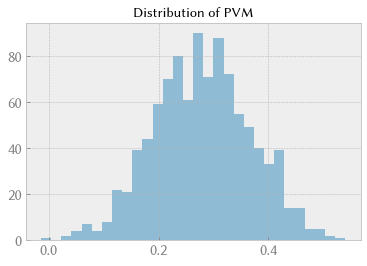

In [ ]:
N = 1000
PVM = numpy.empty(N)
for i in range(N):
    PVM[i] = simulated_PVM(random_input())
plt.hist(PVM, bins=30, alpha=0.5)
plt.title("Distribution of PVM");

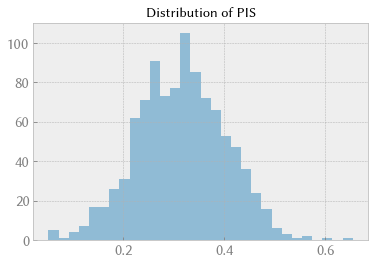

In [ ]:
PIS = numpy.empty(N)
for i in range(N):
    PIS[i] = simulated_PIS(random_input())
plt.hist(PIS, bins=30, alpha=0.5)
plt.title("Distribution of PIS");

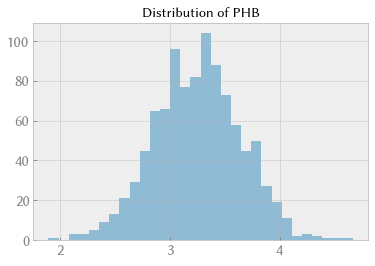

In [ ]:
PHB = numpy.empty(N)
for i in range(N):
    PHB[i] = simulated_PHB(random_input())
plt.hist(PHB, bins=30, alpha=0.5)
plt.title("Distribution of PHB");

Now we can use a stochastic simulation method (here a naïve Monte Carlo method) to estimate the failure probability. We run a simulation with random inputs a large number of times, and count the proportion of simulations where a failure occurred. 

In [ ]:
%%time
N = 100_000
failures = 0
for i in range(N):
    ri = random_input()
    g = numpy.min([simulated_PVM(ri), simulated_PIS(ri), simulated_PHB(ri)])
    if g <= 0:
        failures += 1

CPU times: user 3min 29s, sys: 918 ms, total: 3min 30s
Wall time: 3min 27s


In [ ]:
# the probability of failure. Note that the article estimates this as 0.000697
failures / float(N)

0.00058

## Vectorization

The Jupyter magic code `%%time` used in the cell above leads to the computation time for the cell being printed. As you will have noticed if you’re executing the notebook cell by cell, the element-by-element approach used above (one calculation per loop iteration) is very very slow in Python! 

We can make things run faster using NumPy’s vectorization capabilities, its ability to operate on (add, subtract, take the square root, etc.) vectors of values, and not just on single values. Below, we write the functions that calculate PVM, PIS and PHB in a form that allows vectorization (each argument such as `tplate` can be either a single value or a vector of values). 

In [ ]:
def simulate_PVM(tplate, th, Nx, Ny, Nxy):
    return -1 + 84000.0 * tplate / numpy.sqrt(Nx**2 + Ny**2 - Nx*Ny + 3*Nxy**2)

def simulate_PIS(tplate, th, Nx, Ny, Nxy):
    return -1 + 84000.0 * tplate / numpy.abs(Ny)

def simulate_PHB(tplate, th, Nx, Ny, Nxy):
    x1 = 4 * (tplate - 0.075)
    x2 = 20 * (th - 0.1)
    x3 = -6000 * (1.0/Nxy + 0.003)
    PHB = 0.847 + 0.96 * x1 + 0.986 * x2 - 0.216 * x3 
    PHB += 0.077 * x1**2 + 0.11 * x2**2 + 0.007 * x3**2 
    PHB += 0.378 * x1 * x2 - 0.106 * x1 * x3 - 0.11 * x2 * x3
    return PHB

Now we run the naïve Monte Carlo simulation in vectorized form. We start by generating vectors of values for the 5 input variables, then call the failure calculation functions on these vectors. We can them compare the failure vectors itemwise with a vector full of zeros and count the number of simulations where at least one of the results was negative.

In [ ]:
%%time
N = 10_000_000
tplate = scipy.stats.norm(0.07433, 0.005).rvs(N)
th = scipy.stats.norm(0.1, 0.01).rvs(N)
Nx = scipy.stats.norm(13, 60).rvs(N)
Ny = scipy.stats.norm(4751, 48).rvs(N)
Nxy = scipy.stats.norm(-648, 11).rvs(N)
zeros = numpy.zeros(N)
PVM_fail = numpy.less_equal(simulate_PVM(tplate, th, Nx, Ny, Nxy), zeros)
PIS_fail = numpy.less_equal(simulate_PIS(tplate, th, Nx, Ny, Nxy), zeros)
PHB_fail = numpy.less_equal(simulate_PHB(tplate, th, Nx, Ny, Nxy), zeros)
# this is the number of failures
failures = numpy.sum(numpy.logical_or(PVM_fail, PIS_fail, PHB_fail))
failures / float(N)

CPU times: user 1.51 s, sys: 234 ms, total: 1.75 s
Wall time: 1.74 s


0.0006132

Note that we are running 100 times more simulations here, but the calculation is nevertheless more than 60 times faster. So the vectorization has led to a speedup of a factor of 600.

Calculations of this form are nonetheless not very fast in Python. Another notebook on the [risk-engineering.org website](https://risk-engineering.org/monte-carlo-methods/) shows how to run this calculation in the [Rust programming language](https://www.rust-lang.org/), with much higher performance.

## A Latin Hypercube Sampling (LHS) approach

The LHS method consists of dividing the input space into a number of equiprobable regions, then taking random samples from each region. We can use it conveniently in Python thanks to the [pyDOE library](https://pythonhosted.org/pyDOE/), which you will probably need to install on your computer, using a command such as 

> pip install pyDOE

or if you’re using a Google CoLaboratory notebook, execute a code cell containing

> !pip install pyDOE

The `lhs` function in this library returns an “experimental design” consisting of points in the $[0, 1]^d$ hypercube, where $d$ is the dimension of your problem (it’s 2 in this simple example). You need to scale these points to your input domain. 

In [ ]:
%%time

# obtain the pyDOE library from https://pythonhosted.org/pyDOE/
from pyDOE import lhs

N = 1000_000
seq = lhs(5, N)
tplate = scipy.stats.norm(0.07433, 0.005).ppf(seq[:,0])
th = scipy.stats.norm(0.1, 0.01).ppf(seq[:,1])
Nx = scipy.stats.norm(13, 60).ppf(seq[:,2])
Ny = scipy.stats.norm(4751, 48).ppf(seq[:,3])
Nxy = scipy.stats.norm(-648, 11).ppf(seq[:,4])
zeros = numpy.zeros(N)
PVM_fail = numpy.less_equal(simulate_PVM(tplate, th, Nx, Ny, Nxy), zeros)
PIS_fail = numpy.less_equal(simulate_PIS(tplate, th, Nx, Ny, Nxy), zeros)
PHB_fail = numpy.less_equal(simulate_PHB(tplate, th, Nx, Ny, Nxy), zeros)
failures = numpy.sum(numpy.logical_or(PVM_fail, PIS_fail, PHB_fail))
failures / float(N)

CPU times: user 1.36 s, sys: 242 ms, total: 1.6 s
Wall time: 1.6 s


0.000628

## Using Halton’s low discrepancy sequences

A [low discrepancy (or quasi-random) sequence](https://en.wikipedia.org/wiki/Low-discrepancy_sequence) is a deterministic mathematical sequence of numbers that has the property of low discrepancy. This means (informally) that there are no clusters of points and that the sequence fills space roughly uniformly. The [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) is a low discrepancy sequence that has useful properties for pseudo-stochastic sampling methods (also called “quasi-Monte Carlo” methods). 

In [ ]:
import math

# adapted from https://mail.scipy.org/pipermail/scipy-user/2013-June/034744.html
def halton(dim: int, nbpts: int):
    h = numpy.full(nbpts * dim, numpy.nan)
    p = numpy.full(nbpts, numpy.nan)
    P = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
    lognbpts = math.log(nbpts + 1)
    for i in range(dim):
        b = P[i]
        n = int(math.ceil(lognbpts / math.log(b)))
        for t in range(n):
            p[t] = pow(b, -(t + 1))

        for j in range(nbpts):
            d = j + 1
            sum_ = math.fmod(d, b) * p[0]
            for t in range(1, n):
                d = math.floor(d / b)
                sum_ += math.fmod(d, b) * p[t]

            h[j*dim + i] = sum_
    return h.reshape(nbpts, dim)

In [ ]:
%%time 

N = 1000_000
seq = halton(5, N)
tplate = scipy.stats.norm(0.07433, 0.005).ppf(seq[:,0])
th = scipy.stats.norm(0.1, 0.01).ppf(seq[:,1])
Nx = scipy.stats.norm(13, 60).ppf(seq[:,2])
Ny = scipy.stats.norm(4751, 48).ppf(seq[:,3])
Nxy = scipy.stats.norm(-648, 11).ppf(seq[:,4])
zeros = numpy.zeros(N)
PVM_fail = numpy.less_equal(simulate_PVM(tplate, th, Nx, Ny, Nxy), zeros)
PIS_fail = numpy.less_equal(simulate_PIS(tplate, th, Nx, Ny, Nxy), zeros)
PHB_fail = numpy.less_equal(simulate_PHB(tplate, th, Nx, Ny, Nxy), zeros)
failures = numpy.sum(numpy.logical_or(PVM_fail, PIS_fail, PHB_fail))
failures / float(N)

CPU times: user 27.2 s, sys: 30.2 ms, total: 27.2 s
Wall time: 27.2 s


0.000628

## Attempting an analytical solution

It’s quite easy to specify this problem in analytical terms, using the [SymPy library](https://www.sympy.org/) for symbolic calculation in Python. However, this problem is too complicated for the current version (in 2020) of SymPy, and leads to an error. (It also consumes a large amount of memory before failing.)

In [ ]:
import sympy
import sympy.stats

def analytical_PVM(tplate, th, Nx, Ny, Nxy):
    return -1 + 84000.0 * tplate / sympy.sqrt(Nx**2 + Ny**2 - Nx*Ny + 3*Nxy**2)

tplate = sympy.stats.Normal("tplate", 0.07433, 0.005)
th = sympy.stats.Normal("th", 0.1, 0.01)
Nx = sympy.stats.Normal("Nx", 13, 60)
Ny = sympy.stats.Normal("Ny", 4751, 48)
Nxy = sympy.stats.Normal("Nxy", -648, 11)
# Here we are trying to calculate the probability that PVM (one of the failure modes)
# is <= 0. 
# Don't execute this unless you have more than 32GB of RAM! It uses large amounts of memory 
# and results in an error "Multiple continuous random variables not supported" for a 
# continuous probability space 
# sympy.stats.P(analytical_PVM(tplate, th, Nx, Ny, Nxy) <= 0)

In [ ]:
sympy.stats.P(analytical_PVM(tplate, th, Nx, Ny, Nxy) <= 0)